##Real working


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

In [3]:
input_shape = (224, 224, 3)
batch_size = 32


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
data_dir = "/content/drive/MyDrive/archive (2)/Breast Cancer Patients MRI's/train"
healthy_patient_dir = "/content/drive/MyDrive/archive (2)/Breast Cancer Patients MRI's/train/Healthy"
sick_patient_dir = "/content/drive/MyDrive/archive (2)/Breast Cancer Patients MRI's/train/Sick"

dirlist = [healthy_patient_dir, sick_patient_dir]
classes = ['Healthy', 'Sick']
filepaths = []
labels = []

In [6]:
for i, j in zip(dirlist, classes):
    filelist = os.listdir(i)
    for f in filelist:
        filepath = os.path.join(i, f)
        filepaths.append(filepath)
        labels.append(j)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
Files = pd.Series(filepaths, name='filepaths')
Label = pd.Series(labels, name='labels')
df = pd.concat([Files, Label], axis=1)

In [9]:
train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)


In [10]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test,
    target_size=(224, 224),
    x_col='filepaths',
    y_col='labels',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 71 validated image filenames belonging to 2 classes.


In [11]:
# # ImageDataGenerator for training set with CutMix augmentation
# train_gen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=60,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest',
#     preprocessing_function=tf.keras.applications.resnet.preprocess_input,  # ResNet preprocessing
#     preprocessing_function_densenet=tf.keras.applications.densenet.preprocess_input  # DenseNet preprocessing
# )

In [12]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [13]:
train_gen_flow = train_gen.flow_from_dataframe(
    dataframe=train_new,
    x_col='filepaths',
    y_col='labels',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1205 validated image filenames belonging to 2 classes.


In [14]:
# import math
# import matplotlib.pyplot as plt

# # Get a batch of validation data
# images, labels = train_gen_flow_cutmix .next()

# # Determine the number of rows and columns for the subplot grid
# batch_size = images.shape[0]
# rows = int(math.ceil(batch_size / 8))
# columns = 8

# # Display the images
# fig, axes = plt.subplots(rows, columns, figsize=(15, 8))

# for i, ax in enumerate(axes.flatten()):
#     if i < batch_size:
#         ax.imshow(images[i])
#         ax.axis('off')
#         ax.set_title(f"Label: {int(labels[i])}", pad=10)  # Add padding to the title

# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()


In [15]:
val_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)



In [16]:
val_gen_flow = val_gen.flow_from_dataframe(
    dataframe=valid,
    x_col='filepaths',
    y_col='labels',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary'
)

Found 134 validated image filenames belonging to 2 classes.


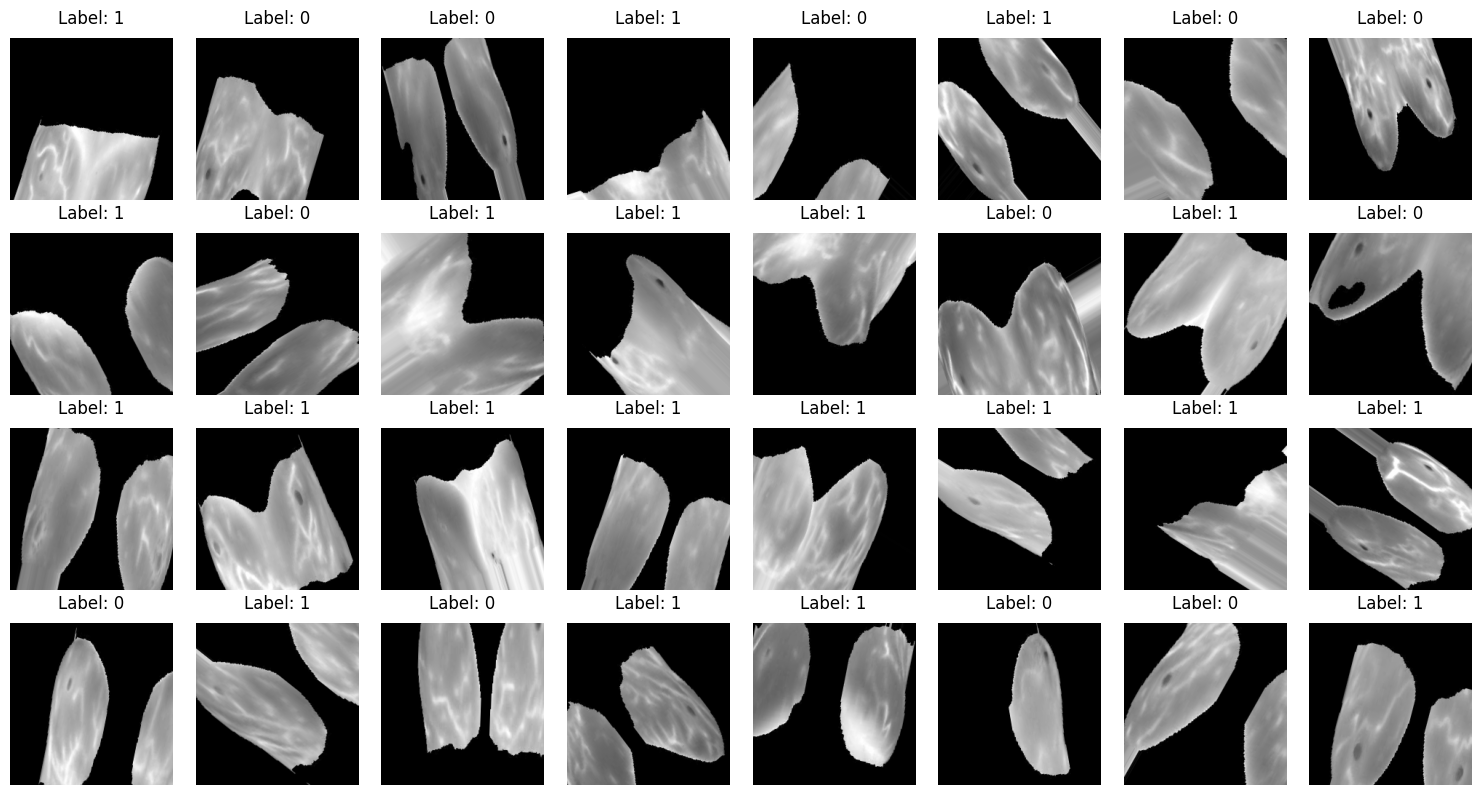

In [17]:

import math
import matplotlib.pyplot as plt

images, labels = val_gen_flow.next()

batch_size = images.shape[0]
rows = int(math.ceil(batch_size / 8))
columns = 8

fig, axes = plt.subplots(rows, columns, figsize=(15, 8))

for i, ax in enumerate(axes.flatten()):
    if i < batch_size:
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(f"Label: {int(labels[i])}", pad=10)

plt.tight_layout()
plt.show()


In [18]:
from tensorflow.keras import layers, models

def create_siamese_model(input_shape):
    base_model_resnet = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    base_model_densenet = tf.keras.applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    input_a = layers.Input(shape=input_shape, name='input_a')
    input_b = layers.Input(shape=input_shape, name='input_b')

    feature_a_resnet = base_model_resnet(input_a)
    feature_b_resnet = base_model_resnet(input_b)

    feature_a_densenet = base_model_densenet(input_a)
    feature_b_densenet = base_model_densenet(input_b)

    concatenated_features = layers.Concatenate(axis=-1)([feature_a_resnet, feature_b_resnet, feature_a_densenet, feature_b_densenet])

    x = layers.Dense(256, activation='relu')(concatenated_features)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    siamese_model = models.Model(inputs=[input_a, input_b], outputs=output, name='siamese_model')

    return siamese_model


In [19]:
input_shape = (224, 224, 3)
siamese_model = create_siamese_model(input_shape)


74836368/74836368 [==============================] - 4s 0us/step


In [20]:
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_a (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_b (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 2048)                 2358771   ['input_a[0][0]',             
                                                          2          'input_b[0][0]']             
                                                                                                  
 densenet201 (Functional)    (None, 1920)                 1832198   ['input_a[0][0]', 

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
# from keras.applications.resnet50 import preprocess_input

import os

# from keras.preprocessing.image import load_img, img_to_array, preprocess_input
import numpy as np

def load_and_preprocess_image(filepath_or_array, target_size=(224, 224)):
    if isinstance(filepath_or_array, str):
        img = load_img(filepath_or_array, target_size=target_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        return img_array
    elif isinstance(filepath_or_array, np.ndarray):
        img_array = preprocess_input(filepath_or_array)
        return img_array
    else:
        print(f"Invalid input: {filepath_or_array}")
        return None

In [22]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

class SiameseDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, target_size=(224, 224), shuffle=True):
        self.df = dataframe
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_df = self.df.iloc[start:end]

        pairs, labels = self.generate_pairs(batch_df)

        return pairs, labels


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_and_preprocess_image(self, filepath):
        if isinstance(filepath, (str, bytes)) and pd.isna(filepath):
            print("Found NaN value in file path.")
            return None

        if isinstance(filepath, (str, bytes)) and os.path.isdir(filepath):
            print(f"Path is a directory: {filepath}")
            return None

        if isinstance(filepath, (str, bytes)) and os.path.isfile(filepath):
            img = load_img(filepath, target_size=self.target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            return img_array
        elif isinstance(filepath, np.ndarray):
            img_array = preprocess_input(filepath)
            return img_array
        else:
            print(f"Invalid file path: {filepath}")
            return None

        if os.path.isfile(filepath):
            img = load_img(filepath, target_size=self.target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            return img_array
        else:
            print(f"Invalid file path: {filepath}")
            return None

    def generate_pairs(self, batch_df):
        num_pairs = len(batch_df)
        pairs = [np.zeros((num_pairs, *self.target_size, 3)) for _ in range(2)]
        labels = np.zeros((num_pairs,))

        for i, (_, row) in enumerate(batch_df.iterrows()):
            filepaths = row['filepaths'].split(',')

            filepaths = [path.strip() for path in filepaths if path.strip() and not pd.isna(path.strip())]

            if len(filepaths) == 1:
                filepaths.append(filepaths[0])

            if len(filepaths) >= 2:
                path_a, path_b = filepaths[:2]

                img_a = self.load_and_preprocess_image(path_a)
                img_b = self.load_and_preprocess_image(path_b)

                if img_a is not None and img_b is not None:
                    pairs[0][i, :, :, :] = img_a
                    pairs[1][i, :, :, :] = img_b

                    labels[i] = 1 if row['labels'] == 'Sick' else 0
                else:
                    print(f"Skipping row {i} with invalid images: {filepaths}")
            else:
                print(f"Skipping row {i} with less than two valid file paths: {filepaths}")

        return pairs, labels







siamese_train_gen = SiameseDataGenerator(train_new, batch_size=16, target_size=(224, 224), shuffle=True)


In [24]:
siamese_val_gen = SiameseDataGenerator(valid, batch_size=16, target_size=(224, 224), shuffle=False)


In [25]:
def lr_schedule(epoch):
    if epoch < 50:
        return 0.001
    elif 50 <= epoch < 75:
        return 0.0001
    else:
        return 0.00001

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Siamese model with both callbacks
history = siamese_model.fit(
    siamese_train_gen,
    epochs=100,
    steps_per_epoch=len(siamese_train_gen),
    validation_data=siamese_val_gen,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
76/76 [==============================] - 655s 6s/step - loss: 0.9372 - accuracy: 0.6589 - val_loss: 3.6502 - val_accuracy: 0.7090 - lr: 0.0010
Epoch 2/100
76/76 [==============================] - 71s 937ms/step - loss: 0.3382 - accuracy: 0.8622 - val_loss: 8.1621 - val_accuracy: 0.4925 - lr: 0.0010
Epoch 3/100
76/76 [==============================] - 72s 944ms/step - loss: 0.2956 - accuracy: 0.8788 - val_loss: 1.9626 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 4/100
76/76 [==============================] - 74s 977ms/step - loss: 0.1983 - accuracy: 0.9286 - val_loss: 0.8270 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 5/100
76/76 [==============================] - 72s 943ms/step - loss: 0.2104 - accuracy: 0.9286 - val_loss: 0.1409 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 6/100
76/76 [==============================] - 74s 972ms/step - loss: 0.2016 - accuracy: 0.9303 - val_loss: 4.3453 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 7/100
76/76 [==============================] - 71s 933

In [26]:
# siamese_val_gen = SiameseDataGenerator(valid, batch_size=16, target_size=(224, 224), shuffle=False)

evaluation_result = siamese_model.evaluate(siamese_val_gen, steps=len(siamese_val_gen))

print(f"Validation Accuracy: {evaluation_result[1] * 100:.2f}%")

9/9 [==============================] - 2s 247ms/step - loss: 0.1409 - accuracy: 0.9328
Validation Accuracy: 93.28%


In [27]:
siamese_test_gen = SiameseDataGenerator(test, batch_size=16, target_size=(224, 224), shuffle=False)

test_evaluation_result = siamese_model.evaluate(siamese_test_gen, steps=len(siamese_test_gen))

print(f"Test Accuracy: {test_evaluation_result[1] * 100:.2f}%")

5/5 [==============================] - 27s 7s/step - loss: 0.3328 - accuracy: 0.9014
Test Accuracy: 90.14%


In [28]:
train_evaluation_result = siamese_model.evaluate(siamese_train_gen, steps=len(siamese_train_gen))

print(f"Training Accuracy: {train_evaluation_result[1] * 100:.2f}%")

76/76 [==============================] - 21s 270ms/step - loss: 0.1450 - accuracy: 0.9444
Training Accuracy: 94.44%


5/5 [==============================] - 9s 232ms/step


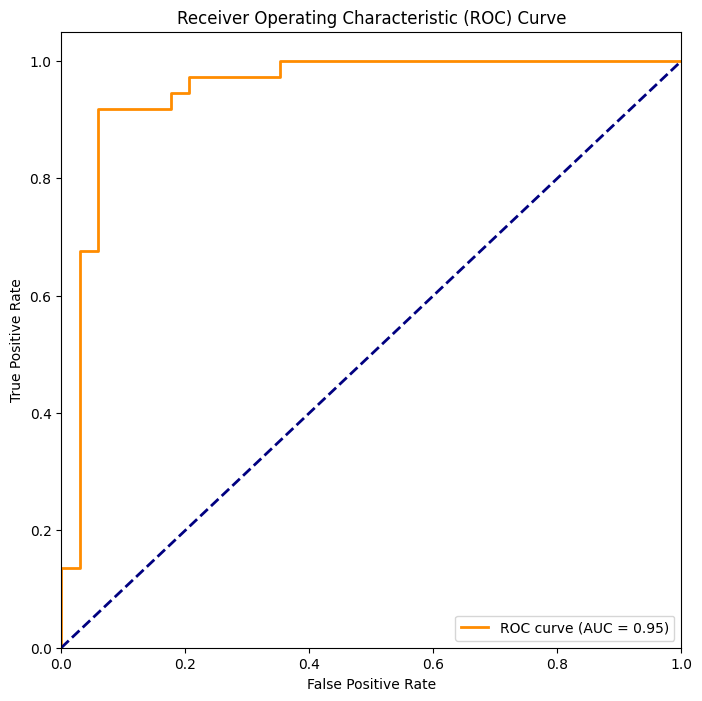

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_predictions = siamese_model.predict(siamese_test_gen)

true_labels = siamese_test_gen.df['labels'].map({'Healthy': 0, 'Sick': 1}).values.flatten()

fpr, tpr, _ = roc_curve(true_labels, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Number of samples in the test set: 71
5/5 [==============================] - 1s 230ms/step


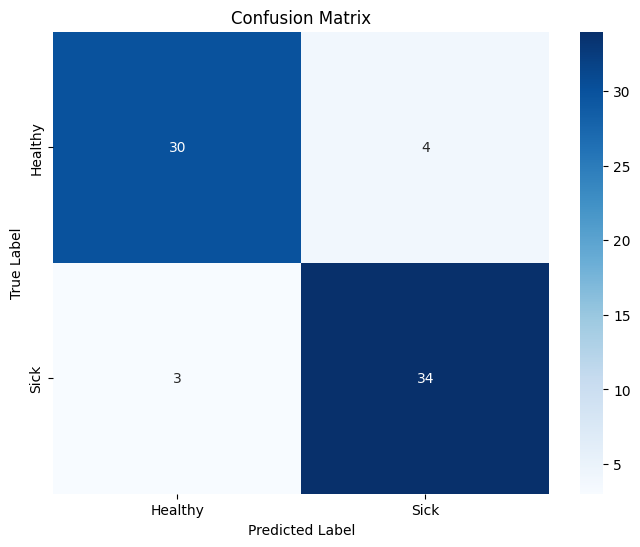

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.88      0.90        34
        Sick       0.89      0.92      0.91        37

    accuracy                           0.90        71
   macro avg       0.90      0.90      0.90        71
weighted avg       0.90      0.90      0.90        71



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("Number of samples in the test set:", len(siamese_test_gen.df))

test_predictions = siamese_model.predict(siamese_test_gen)

binary_predictions = (test_predictions > 0.5).astype(int)

true_labels = siamese_test_gen.df['labels'].map({'Healthy': 0, 'Sick': 1}).values

cm = confusion_matrix(true_labels, binary_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, binary_predictions, target_names=['Healthy', 'Sick']))


76/76 [==============================] - 20s 263ms/step


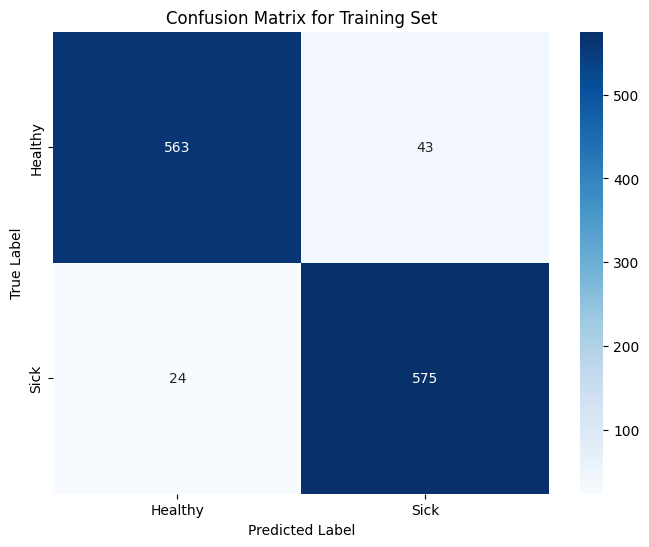

Classification Report for Training Set:
              precision    recall  f1-score   support

     Healthy       0.96      0.93      0.94       606
        Sick       0.93      0.96      0.94       599

    accuracy                           0.94      1205
   macro avg       0.94      0.94      0.94      1205
weighted avg       0.94      0.94      0.94      1205



In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

train_predictions = siamese_model.predict(siamese_train_gen)

binary_train_predictions = (train_predictions > 0.5).astype(int)

true_train_labels = siamese_train_gen.df['labels'].map({'Healthy': 0, 'Sick': 1}).values

train_cm = confusion_matrix(true_train_labels, binary_train_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
plt.title('Confusion Matrix for Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report for Training Set:")
print(classification_report(true_train_labels, binary_train_predictions, target_names=['Healthy', 'Sick']))
